# Titanic Dataset - Feature Engineering

**Student:** Arthur Gislon Leonida

**Objective:** This dataset aims to predict the survival of passengers on the Titanic.

**Dataset URL:** https://www.kaggle.com/competitions/titanic

**Data Dictionary:**

* **survival:** Survival (0 = No, 1 = Yes) - That's the **TARGET**

* **pclass:** Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)

* **sex:** Sex	

* **Age:** Age in years	

* **sibsp:** # of siblings / spouses aboard the Titanic	

* **parch:** # of parents / children aboard the Titanic	

* **ticket:**	Ticket number	

* **fare:** Passenger fare	

* **cabin:** Cabin number	

* **embarked:** Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

## 1. Setup and Library Imports

Loading all necessary libraries for data manipulation, visualization, machine learning, and feature engineering.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import shap
import ipykernel
from scipy.stats import boxcox
from helper_functions import adaptive_binning, robust_outlier_detection, mutual_information, hsic
from sklearn import set_config
import optuna as opt

# This tells all scikit-learn transformers to output pandas DataFrames
set_config(transform_output="pandas")

print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("sklearn version:", sklearn.__version__)
print("xgboost version:", xgb.__version__)
print("numpy version:", np.__version__)
print("shap version:", shap.__version__)
print("optuna version:", opt.__version__)
print("ipykernel version:", ipykernel.__version__)
print('python version:', os.popen('python --version').read().strip())

pandas version: 2.3.3
matplotlib version: 3.10.7
seaborn version: 0.13.2
sklearn version: 1.7.2
xgboost version: 2.1.0
numpy version: 2.2.6
shap version: 0.49.1
optuna version: 4.6.0
ipykernel version: 6.29.5
python version: Python 3.10.19


/home/ubuntu/miniconda3/envs/whisper_proj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
features_description = {
    'PassengerId': 'Passenger ID',
    'Survived': 'Survival (0 = No; 1 = Yes)',
    'Pclass': 'Passenger Class (1st, 2nd, 3rd)',
    'Name': 'Passenger Name',
    'Sex': 'Gender',
    'Age': 'Age in years',
    'SibSp': 'Number of Siblings/Spouses Aboard',
    'Parch': 'Number of Parents/Children Aboard',
    'Ticket': 'Ticket Number',
    'Fare': 'Passenger Fare',
    'Cabin': 'Cabin Number',
    'Embarked': 'Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)'
}

## 2. Data Loading and Initial Split

Loading the Titanic dataset and splitting it into training (80%) and validation (20%) sets using stratified sampling to maintain the class distribution.

In [3]:
# The downloaded dataset has a file named 'Salary Prediction of Data Professions.csv'
train_file_path = 'data/train.csv'
# test_file_path = 'data/test.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(train_file_path)
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Survived'])

# I won't use this because it doesn't have the target variable (it was made for kaggle competition)
# test_df = pd.read_csv(test_file_path)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Extract the first letter from the 'Cabin' column (filling NaNs with 'U' for Unknown)
available_decks = df['Cabin'].fillna('U').str[0].unique()

# Sort them to see them in order
available_decks.sort()

print(f"Available Decks: {available_decks}")

Available Decks: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'T' 'U']


## 3. Initial Data Exploration

Exploring the available cabin decks and checking for missing values in the dataset.

In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

---

# PART 1: BASELINE MODEL

## 4. Baseline Preprocessing Pipeline

Creating a simple baseline preprocessing pipeline that:
- Imputes missing numerical values with the mean
- Imputes missing categorical values with the most frequent value
- One-hot encodes categorical features
- Drops unnecessary columns (Name, Ticket, Cabin)

This baseline will serve as a benchmark to measure the improvement from feature engineering.

**Reference:** https://www.youtube.com/watch?v=fATVVQfFyU0

In [6]:
# 1. Define which columns are which type
numeric_features = []
categorical_features = []
for col in df_train.drop('Survived', axis=1).columns:
    # check col type
    if df_train[col].dtype == 'object':
        categorical_features.append(col)
    else:    
        numeric_features.append(col)

# 2. Create the preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. Combine preprocessing steps into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # This ensures columns like 'Name', 'Ticket', and 'Cabin' are dropped
)

# 4. Create the final, simple baseline pipeline
baseline_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

## 5. Training the Baseline Model

Training an untuned XGBoost classifier on the preprocessed baseline features to establish initial performance.

In [7]:
X_train_base = df_train.drop('Survived', axis=1)
y_train_base = df_train['Survived']
X_val_base = df_val.drop('Survived', axis=1)
y_val_base = df_val['Survived']

X_train_base_processed = baseline_pipeline.fit_transform(X_train_base)
X_val_base_processed = baseline_pipeline.transform(X_val_base)

In [8]:
# Train baseline model
baseline_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
baseline_model.fit(X_train_base_processed, y_train_base)

# Evaluate baseline model
preds_base = baseline_model.predict(X_val_base_processed)
baseline_accuracy = accuracy_score(y_val_base, preds_base)

print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")

Baseline Model Accuracy: 0.7263


## 6. Hyperparameter Tuning for Baseline Model

Using Optuna to find optimal hyperparameters for XGBoost through 100 trials with 5-fold cross-validation. This will show how much improvement can be gained from tuning alone, without feature engineering.

In [9]:
def objective(trial, X, y):
    """
    The objective function for Optuna to optimize using Cross-Validation.
    A 'trial' is a single run with a specific set of hyperparameters.
    """
    # Suggest hyperparameters for XGBoost
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1, 10), # L2 regularization
        'alpha': trial.suggest_float('alpha', 0, 10),    # L1 regularization
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)
    
    # Use 5-fold stratified cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    # Return mean accuracy across all folds
    return scores.mean()

In [10]:
# Combine train and validation for cross-validation
X_full_base = pd.concat([X_train_base_processed, X_val_base_processed], axis=0)
y_full_base = pd.concat([y_train_base, y_val_base], axis=0)

study = opt.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_full_base, y_full_base), n_trials=100)

print("\nBest hyperparameters found:")

print(study.best_params)
print(study.best_value)

print("\nBest CV Accuracy:")

[I 2025-12-10 00:45:04,630] A new study created in memory with name: no-name-8c78d300-e8eb-4a1d-89dc-970b435ab85b


[I 2025-12-10 00:45:06,979] Trial 0 finished with value: 0.792379637185362 and parameters: {'n_estimators': 200, 'learning_rate': 0.2011066892917863, 'max_depth': 6, 'subsample': 0.8852460057476866, 'colsample_bytree': 0.8857581969439636, 'gamma': 4.9195587262720295, 'lambda': 6.094490193800196, 'alpha': 6.6454800775576395}. Best is trial 0 with value: 0.792379637185362.
[I 2025-12-10 00:45:08,809] Trial 1 finished with value: 0.8148389931579938 and parameters: {'n_estimators': 100, 'learning_rate': 0.07849367040758143, 'max_depth': 6, 'subsample': 0.6061615648942785, 'colsample_bytree': 0.8534890234356808, 'gamma': 3.5589174367759817, 'lambda': 5.097322718325993, 'alpha': 0.3793695120528606}. Best is trial 1 with value: 0.8148389931579938.
[I 2025-12-10 00:45:08,809] Trial 1 finished with value: 0.8148389931579938 and parameters: {'n_estimators': 100, 'learning_rate': 0.07849367040758143, 'max_depth': 6, 'subsample': 0.6061615648942785, 'colsample_bytree': 0.8534890234356808, 'gamma':


Best hyperparameters found:
{'n_estimators': 700, 'learning_rate': 0.28949972666263935, 'max_depth': 10, 'subsample': 0.9307762770322442, 'colsample_bytree': 0.7070186134850909, 'gamma': 0.7116360345312956, 'lambda': 3.9695243357231638, 'alpha': 3.5903237330141686}
0.831680371602536

Best CV Accuracy:


In [11]:
# Train baseline model
baseline_model_tuned = xgb.XGBClassifier(
    n_estimators=study.best_params['n_estimators'],
    learning_rate=study.best_params['learning_rate'],
    max_depth=study.best_params['max_depth'],
    subsample=study.best_params['subsample'],
    colsample_bytree=study.best_params['colsample_bytree'],
    gamma=study.best_params['gamma'],
    lambda_=study.best_params['lambda'],
    alpha=study.best_params['alpha'],
    random_state=42,
    eval_metric='logloss'
)

baseline_model_tuned.fit(X_train_base_processed, y_train_base)

# Evaluate baseline model
preds_base = baseline_model_tuned.predict(X_val_base_processed)
baseline_tuned_accuracy = accuracy_score(y_val_base, preds_base)

print(f"Baseline Tuned Model Accuracy: {baseline_tuned_accuracy:.4f}")

/home/ubuntu/miniconda3/envs/whisper_proj/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:49:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


Baseline Tuned Model Accuracy: 0.8045


In [12]:
X_val_base_processed.head()
X_val_base_processed.dtypes

num__PassengerId    float64
num__Pclass         float64
num__Age            float64
num__SibSp          float64
num__Parch          float64
                     ...   
cat__Cabin_G6       float64
cat__Cabin_T        float64
cat__Embarked_C     float64
cat__Embarked_Q     float64
cat__Embarked_S     float64
Length: 1421, dtype: object

## 7. SHAP Feature Importance Analysis (Baseline Models)

Using SHAP (SHapley Additive exPlanations) to understand which features contribute most to the baseline model predictions. This provides interpretability and helps identify which raw features are most predictive.


SHAP with Baseline Model Summary Plot:


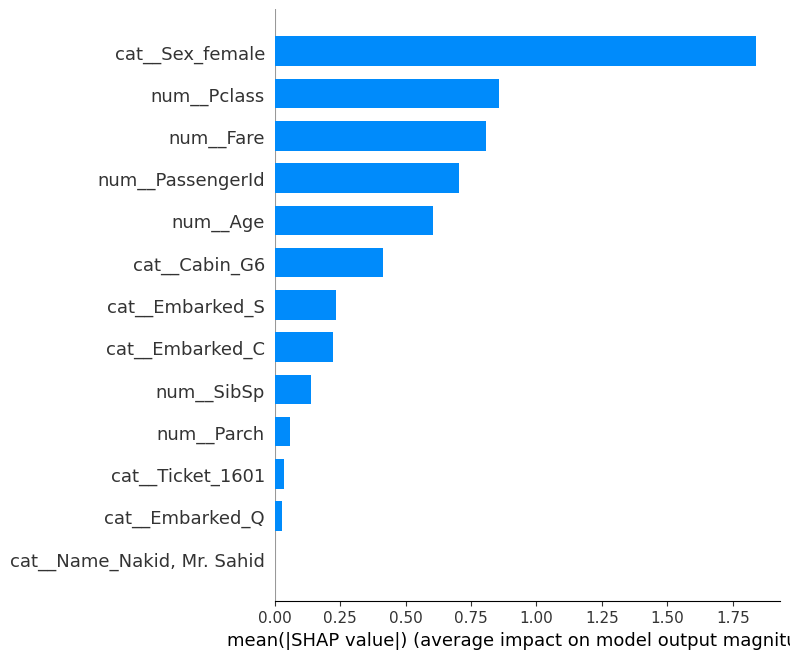

In [13]:
explainer = shap.TreeExplainer(baseline_model)
shap_values = explainer.shap_values(X_val_base_processed)
print(f"\nSHAP with Baseline Model Summary Plot:")
shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=13)


SHAP with Tuned Baseline Model Summary Plot:


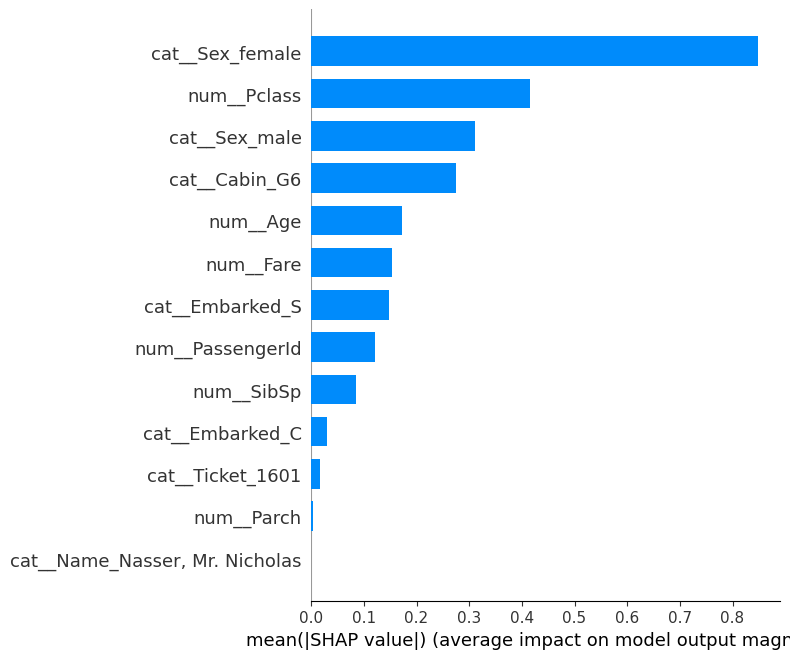

In [14]:
# Use TreeExplainer for XGBoost models
explainer = shap.TreeExplainer(baseline_model_tuned)
shap_values = explainer.shap_values(X_val_base_processed)
print(f"\nSHAP with Tuned Baseline Model Summary Plot:")
shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=13)

---

# PART 2: FEATURE ENGINEERING PIPELINE

This section implements advanced feature engineering techniques to create more informative features that may improve model performance.

## 8. Custom Transformer Classes

Building reusable sklearn-compatible transformers for the feature engineering pipeline:

### Transformers Overview:
- **AgeImputer**: Imputes missing Age values using mean strategy
- **EmbarkedImputer**: Imputes missing Embarked values using most frequent strategy
- **TitleExtractor**: Extracts passenger titles from names (Mr, Miss, Mrs, Master, Other)
- **CabinExtractor**: Extracts cabin deck letter and counts number of cabins per passenger
- **FamilySizeCreator**: Creates interaction feature = SibSp + Parch + 1 (total family size)
- **BinningTransformer**: Applies optimal binning to continuous features using adaptive binning
- **FeatureEncoder**: 
  - Uses One-Hot Encoding for nominal variables (Embarked, Sex, Title)
  - Uses Label Encoding for CabinDeck (ordinal hierarchy)
- **FeatureDropper**: Removes unnecessary columns (PassengerId, Name, Ticket, Cabin)

In [15]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

class EmbarkedImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy='most_frequent')
        X['Embarked'] = imputer.fit_transform(X[['Embarked']])
        return X

class TitleExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Title'] = X['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
        common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
        X['Title'] = X['Title'].apply(lambda x: x if x in common_titles else 'Other')
        return X

class CabinExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
       # Fill missing cabins with 'U' for 'Unknown'
        cabins = X['Cabin'].fillna('U')
        
        # Extract the first letter as Cabin Deck
        X['CabinDeck'] = cabins.str[0]
        
        # Count the number of cabins (your logic was already correct)
        X['CabinCount'] = X['Cabin'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

        return X

class FamilySizeCreator(BaseEstimator, TransformerMixin):
    """
    Creates interaction feature: FamilySize = SibSp + Parch + 1 (self)
    This represents the total number of family members traveling together.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Interaction: Combine siblings/spouses + parents/children + self
        X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
        return X
    
class FeatureEncoder(BaseEstimator, TransformerMixin):
    """
    Encodes categorical and nominal features.
    - Uses One-Hot Encoding for nominal variables (Embarked, Sex, Title)
    - Uses Label Encoding for CabinDeck (ordinal-like with deck hierarchy)
    """
    def __init__(self, available_decks=None):
        self.available_decks = available_decks if available_decks is not None else []
        self.ohe = None
        self.ohe_feature_names = []
        
    def fit(self, X, y=None):
        # Fit OneHotEncoder on the nominal categorical columns
        categorical_cols = ['Embarked', 'Sex', 'Title']
        self.ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.ohe.fit(X[categorical_cols])
        
        # Store feature names for later use
        self.ohe_feature_names = self.ohe.get_feature_names_out(categorical_cols)
        
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Apply One-Hot Encoding to nominal variables
        categorical_cols = ['Embarked', 'Sex', 'Title']
        ohe_encoded = self.ohe.transform(X[categorical_cols])
        
        # Convert to DataFrame with proper column names
        ohe_df = pd.DataFrame(
            ohe_encoded, 
            columns=self.ohe_feature_names,
            index=X.index
        )
        
        # Drop original categorical columns
        X = X.drop(columns=categorical_cols)
        
        # Concatenate the one-hot encoded features
        X = pd.concat([X, ohe_df], axis=1)
        
        # Encode CabinDeck as ordinal (deck hierarchy might matter)
        if len(self.available_decks) > 0:
            cabin_deck_mapping = {deck: idx for idx, deck in enumerate(self.available_decks)}
            # Map and fill unknown with the last index (Unknown)
            unknown_idx = len(self.available_decks)
            X['CabinDeck'] = X['CabinDeck'].map(cabin_deck_mapping).fillna(unknown_idx).astype(int)
        
        return X

class FeatureScaler(BaseEstimator, TransformerMixin):
    """Applies StandardScaler to all numerical columns."""
    def __init__(self):
        self.scaler = StandardScaler()
        self.numerical_cols = []

    def fit(self, X, y=None):
        # Identify numerical columns to be scaled
        self.numerical_cols = X.drop('Survived', axis=1).select_dtypes(include=np.number).columns.tolist()
        if self.numerical_cols:
            self.scaler.fit(X[self.numerical_cols])
        return self

    def transform(self, X):
        if self.numerical_cols:
            X[self.numerical_cols] = self.scaler.transform(X[self.numerical_cols])
        return X

class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X):
        return X.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, errors='ignore')

## 9. Binning Strategy: Adaptive Binning

Implementing optimal binning for continuous features (Age, Fare) using adaptive algorithms. The binning transformer:
1. Determines the optimal number of bins using the `adaptive_binning` function
2. Creates quantile-based bins to ensure roughly equal sample counts per bin
3. Generates new integer-valued bin features (Age_Bin, Fare_Bin)
4. Keeps both the original continuous features and the binned versions

In [ ]:
class BinningTransformer(BaseEstimator, TransformerMixin):
    """
    Applies optimal binning to continuous features using adaptive_binning.
    Creates new binned columns (e.g., Age_Bin, Fare_Bin) as discrete variables.
    """
    def __init__(self, features_to_bin=None):
        self.features_to_bin = features_to_bin if features_to_bin else ['Age', 'Fare']
        self.bin_edges_ = {}
        self.n_bins_ = {}
    
    def fit(self, X, y=None):
        """Learn optimal bin edges from training data."""
        for feature in self.features_to_bin:
            if feature in X.columns:
                # Get optimal number of bins using adaptive_binning
                feature_data = X[feature].dropna()
                
                if len(feature_data) > 0:
                    self.n_bins_[feature] = adaptive_binning(feature_data)
                    
                    # Create bin edges using quantiles
                    quantiles = np.linspace(0, 1, self.n_bins_[feature] + 1)
                    self.bin_edges_[feature] = X[feature].quantile(quantiles).unique()
                    
                    # If it gets fewer unique edges than expected (due to duplicates), fall back to equal-width binning
                    if len(self.bin_edges_[feature]) < 3:
                        self.bin_edges_[feature] = np.linspace(
                            X[feature].min(), 
                            X[feature].max(), 
                            self.n_bins_[feature] + 1
                        )
        return self
    
    def transform(self, X):
        """Apply binning transformation to create new binned features."""
        for feature in self.features_to_bin:
            if feature in X.columns and feature in self.bin_edges_:
                # Create binned version of the feature
                # Use labels=False to get integer bin indices (0, 1, 2, ...)
                X[f'{feature}_Bin'] = pd.cut(
                    X[feature], 
                    bins=self.bin_edges_[feature],
                    labels=False,
                    include_lowest=True,
                    duplicates='drop'
                )
                
                # Fill any NaN values in the binned column with -1 (for missing values)
                X[f'{feature}_Bin'] = X[f'{feature}_Bin'].fillna(-1).astype(int)
        
        return X

## 10. Applying the Feature Engineering Pipeline

Assembling all transformers into a single pipeline and applying them to both training and validation sets. This ensures consistent feature engineering across all data.

In [17]:
pipeline = Pipeline(steps=[
    ('age_imputer', AgeImputer()),
    ('embarked_imputer', EmbarkedImputer()),
    ('title_extractor', TitleExtractor()),
    ('cabin_extractor', CabinExtractor()),
    ('family_size', FamilySizeCreator()),
    ('binning', BinningTransformer(features_to_bin=['Age', 'Fare'])),
    ('feature_encoder', FeatureEncoder(available_decks=available_decks)),
    ('feature_dropper', FeatureDropper())
])

# Create copies for the next feature engineering steps
df_eng_train = df_train.copy()
df_eng_val = df_val.copy()

df_eng_train = pipeline.fit_transform(df_eng_train)
df_eng_val = pipeline.transform(df_eng_val)

/home/ubuntu/miniconda3/envs/whisper_proj/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [18]:
df_eng_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,CabinDeck,CabinCount,FamilySize,Age_Bin,...,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
692,1,3,29.807687,0,0,56.4958,8,0,1,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
481,0,2,29.807687,0,0,0.0000,8,0,1,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
527,0,1,29.807687,0,0,221.7792,2,1,1,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
855,1,3,18.000000,0,1,9.3500,8,0,2,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
801,1,2,31.000000,1,1,26.2500,8,0,3,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
features = df_eng_train.drop(['Survived'], axis=1)
features.head()

,Pclass,Age,SibSp,Parch,Fare,CabinDeck,CabinCount,FamilySize,Age_Bin,Fare_Bin,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
692,3,29.807687,0,0,56.4958,8,0,1,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
481,2,29.807687,0,0,0.0000,8,0,1,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
527,1,29.807687,0,0,221.7792,2,1,1,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
855,3,18.000000,0,1,9.3500,8,0,2,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
801,2,31.000000,1,1,26.2500,8,0,3,1,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## 11. Analyzing Feature Distributions

Visualizing the distribution of all engineered numerical features to understand their characteristics and identify skewness.

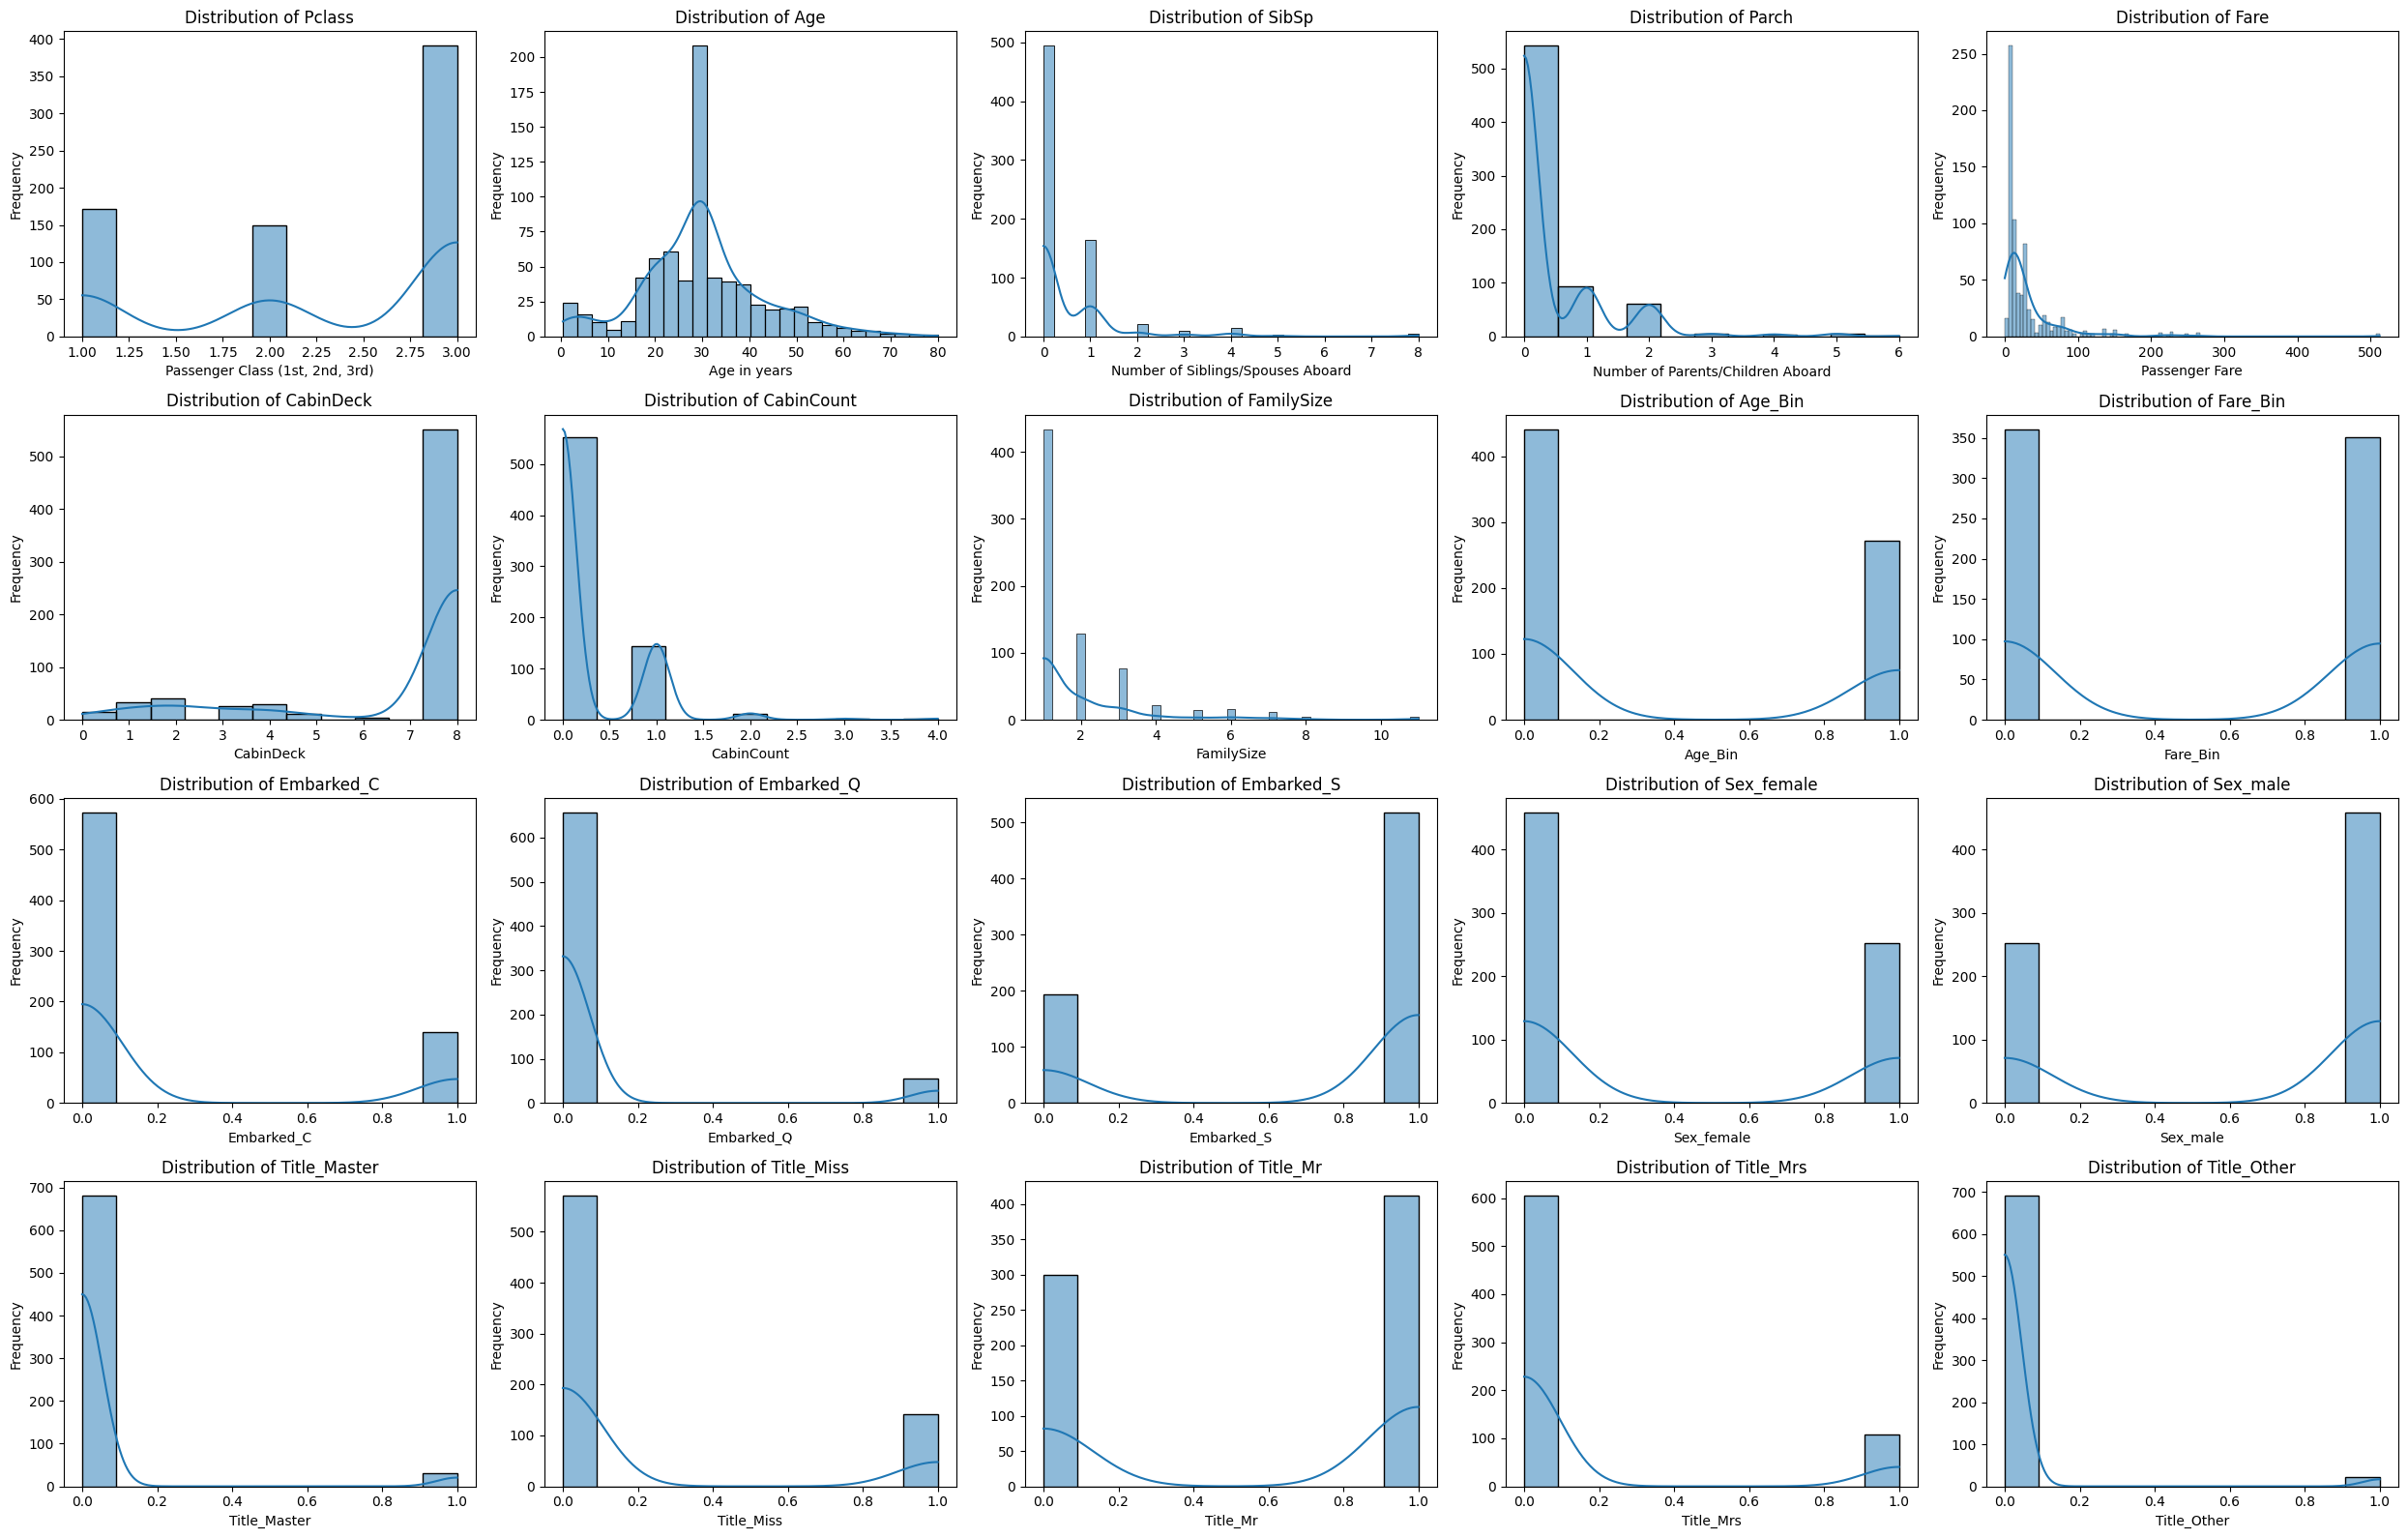

In [20]:
numeric_features = features.select_dtypes(include=['number']).columns
num_plots = len(numeric_features)
cols = 5
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df_eng_train[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(features_description.get(feature, feature))
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 12. Skewness Analysis and Transformation Strategy

After analyzing feature distributions, we identify highly skewed features that need transformation:
- **Highly skewed (|skew| > 1.5)**: Require stronger transformation
- **Moderately skewed (1.0 < |skew| ≤ 1.5)**: May benefit from transformation

Our transformation strategy:
- **Fare**: Box-Cox transformation (continuous, strictly positive)
- **SibSp, Parch, CabinCount**: Log1p transformation (includes zeros, right-skewed)

In [40]:
# Calculate skewness for all numerical features
numerical_features = df_eng_train.select_dtypes(include=np.number).columns
skewness = df_eng_train[numerical_features].skew().sort_values(ascending=False)

print("Skewness of Numerical Features (Top 10):")
print(skewness.head(10))

# Categorize features by skewness level
highly_skewed_features = skewness[(abs(skewness) > 1.5)].index.tolist()
moderate_skewed_features = skewness[(abs(skewness) > 1) & (abs(skewness) <= 1.5)].index.tolist()

print(f"\n\nHighly skewed features (|skew| > 1.5): {len(highly_skewed_features)} features")
print(highly_skewed_features)

print(f"\n\nModerately skewed features (1.0 < |skew| ≤ 1.5): {len(moderate_skewed_features)} features")
print(moderate_skewed_features)

# Identify which features to transform
print("\n\n--- Transformation Strategy ---")
print("Box-Cox: Fare (continuous, strictly positive)")
print("Log1p: SibSp, Parch, CabinCount (count data with zeros)")

Skewness of Numerical Features (Top 10):
Title_Other                   5.573687
Title_Master                  4.483069
Embarked_Q                    3.173576
FamilySize                    2.718601
Title_Mrs                     1.961445
log_transformer_Parch         1.716580
log_transformer_SibSp         1.715546
log_transformer_CabinCount    1.623008
Embarked_C                    1.541067
Title_Miss                    1.518649
dtype: float64


Highly skewed features (|skew| > 1.5): 11 features
['Title_Other', 'Title_Master', 'Embarked_Q', 'FamilySize', 'Title_Mrs', 'log_transformer_Parch', 'log_transformer_SibSp', 'log_transformer_CabinCount', 'Embarked_C', 'Title_Miss', 'CabinDeck']


Moderately skewed features (1.0 < |skew| ≤ 1.5): 1 features
['Embarked_S']


--- Transformation Strategy ---
Box-Cox: Fare (continuous, strictly positive)
Log1p: SibSp, Parch, CabinCount (count data with zeros)


In [23]:
for feature in numeric_features:
    print(f"Feature: {feature}, Min: {df_eng_train[feature].min()}, Max: {df_eng_train[feature].max()}, Skewness: {skewness[feature]}")

Feature: Pclass, Min: 1, Max: 3, Skewness: -0.6305889933530613
Feature: Age, Min: 0.42, Max: 80.0, Skewness: 0.3929032564092265
Feature: SibSp, Min: 0, Max: 8, Skewness: 3.815616890290602
Feature: Parch, Min: 0, Max: 6, Skewness: 2.8425616406990657
Feature: Fare, Min: 0.0, Max: 512.3292, Skewness: 4.64618995113625
Feature: CabinDeck, Min: 0, Max: 8, Skewness: -1.6109490303107281
Feature: CabinCount, Min: 0, Max: 4, Skewness: 2.5458179262975302
Feature: FamilySize, Min: 1, Max: 11, Skewness: 2.7186010356500696
Feature: Age_Bin, Min: 0, Max: 1, Skewness: 0.492789481898481
Feature: Fare_Bin, Min: 0, Max: 1, Skewness: 0.028152002298041538
Feature: Embarked_C, Min: 0.0, Max: 1.0, Skewness: 1.541066809056017
Feature: Embarked_Q, Min: 0.0, Max: 1.0, Skewness: 3.1735760514844626
Feature: Embarked_S, Min: 0.0, Max: 1.0, Skewness: -1.024225805716848
Feature: Sex_female, Min: 0.0, Max: 1.0, Skewness: 0.6057829774753115
Feature: Sex_male, Min: 0.0, Max: 1.0, Skewness: -0.6057829774753115
Feature: 

## 13. Implementing Transformation Classes

Creating custom transformers for:
- **BoxCoxTransformer**: Applies Box-Cox power transformation with optimal λ learned from training data
- **Log Transform**: Applies log1p (log(1+x)) transformation to handle zero values

In [24]:
# Apply Box-Cox transformation
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    """
    Applies the Box-Cox transformation to a list of specified numerical columns.
    """
    def __init__(self, features=None):
        # Store the list of feature names to be transformed
        self.features = features
        self.lambdas_ = {}

    def fit(self, X, y=None):
        # Learn the optimal lambda for each feature from the training data
        for feature in self.features:
            feature_data = X[feature] + 1  # Box-Cox requires positive values
            _, self.lambdas_[feature] = boxcox(feature_data)
        return self

    def transform(self, X):
        for feature in self.features:
            feature_data = X[feature] + 1
            # Apply the transformation using the lambda learned during fit
            X[feature] = boxcox(feature_data, lmbda=self.lambdas_[feature])
        return X

# Apply log1p transformation
def apply_log_transform(X):
    """Applies a log1p transformation."""
    return np.log1p(X)

## 14. Applying Transformations to Engineered Features

Creating a transformation pipeline that applies:
- Log1p transformation to count features (SibSp, Parch, CabinCount)
- Box-Cox transformation to Fare
- Keeps all other features unchanged

This reduces skewness and makes distributions more normal, which can improve model performance.

In [26]:
features_to_bc_transform = ['Fare']
features_to_log_transform = ['SibSp', 'Parch', 'CabinCount']

preprocessor = ColumnTransformer(
    transformers=[
        ('log_transformer', FunctionTransformer(apply_log_transform), features_to_log_transform),
        ('boxcox_transformer', BoxCoxTransformer(features=features_to_bc_transform), features_to_bc_transform)
    ],
    remainder='passthrough' # Keep other columns ('Age')
)

transform_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

df_eng_train = transform_pipeline.fit_transform(df_eng_train)
df_eng_val = transform_pipeline.transform(df_eng_val)

df_eng_train.columns = df_eng_train.columns.str.replace('remainder__', '').str.replace('log_transformer__', 'log_transformer_').str.replace('boxcox_transformer__', 'boxcox_transformer_')
df_eng_val.columns = df_eng_val.columns.str.replace('remainder__', '').str.replace('log_transformer__', 'log_transformer_').str.replace('boxcox_transformer__', 'boxcox_transformer_')

df_eng_train.head()

,log_transformer_SibSp,log_transformer_Parch,log_transformer_CabinCount,boxcox_transformer_Fare,Survived,Pclass,Age,CabinDeck,FamilySize,Age_Bin,...,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
692,0.000000,0.000000,0.000000,3.486357,1,3,29.807687,8,1,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
481,0.000000,0.000000,0.000000,0.000000,0,2,29.807687,8,1,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
527,0.000000,0.000000,0.693147,4.431708,0,1,29.807687,2,1,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
855,0.000000,0.693147,0.000000,2.140875,1,3,18.000000,8,2,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
801,0.693147,0.693147,0.000000,2.922005,1,2,31.000000,8,3,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## 15. Visualizing Transformed Features

Visualizing the distributions after transformation to verify that skewness has been reduced.

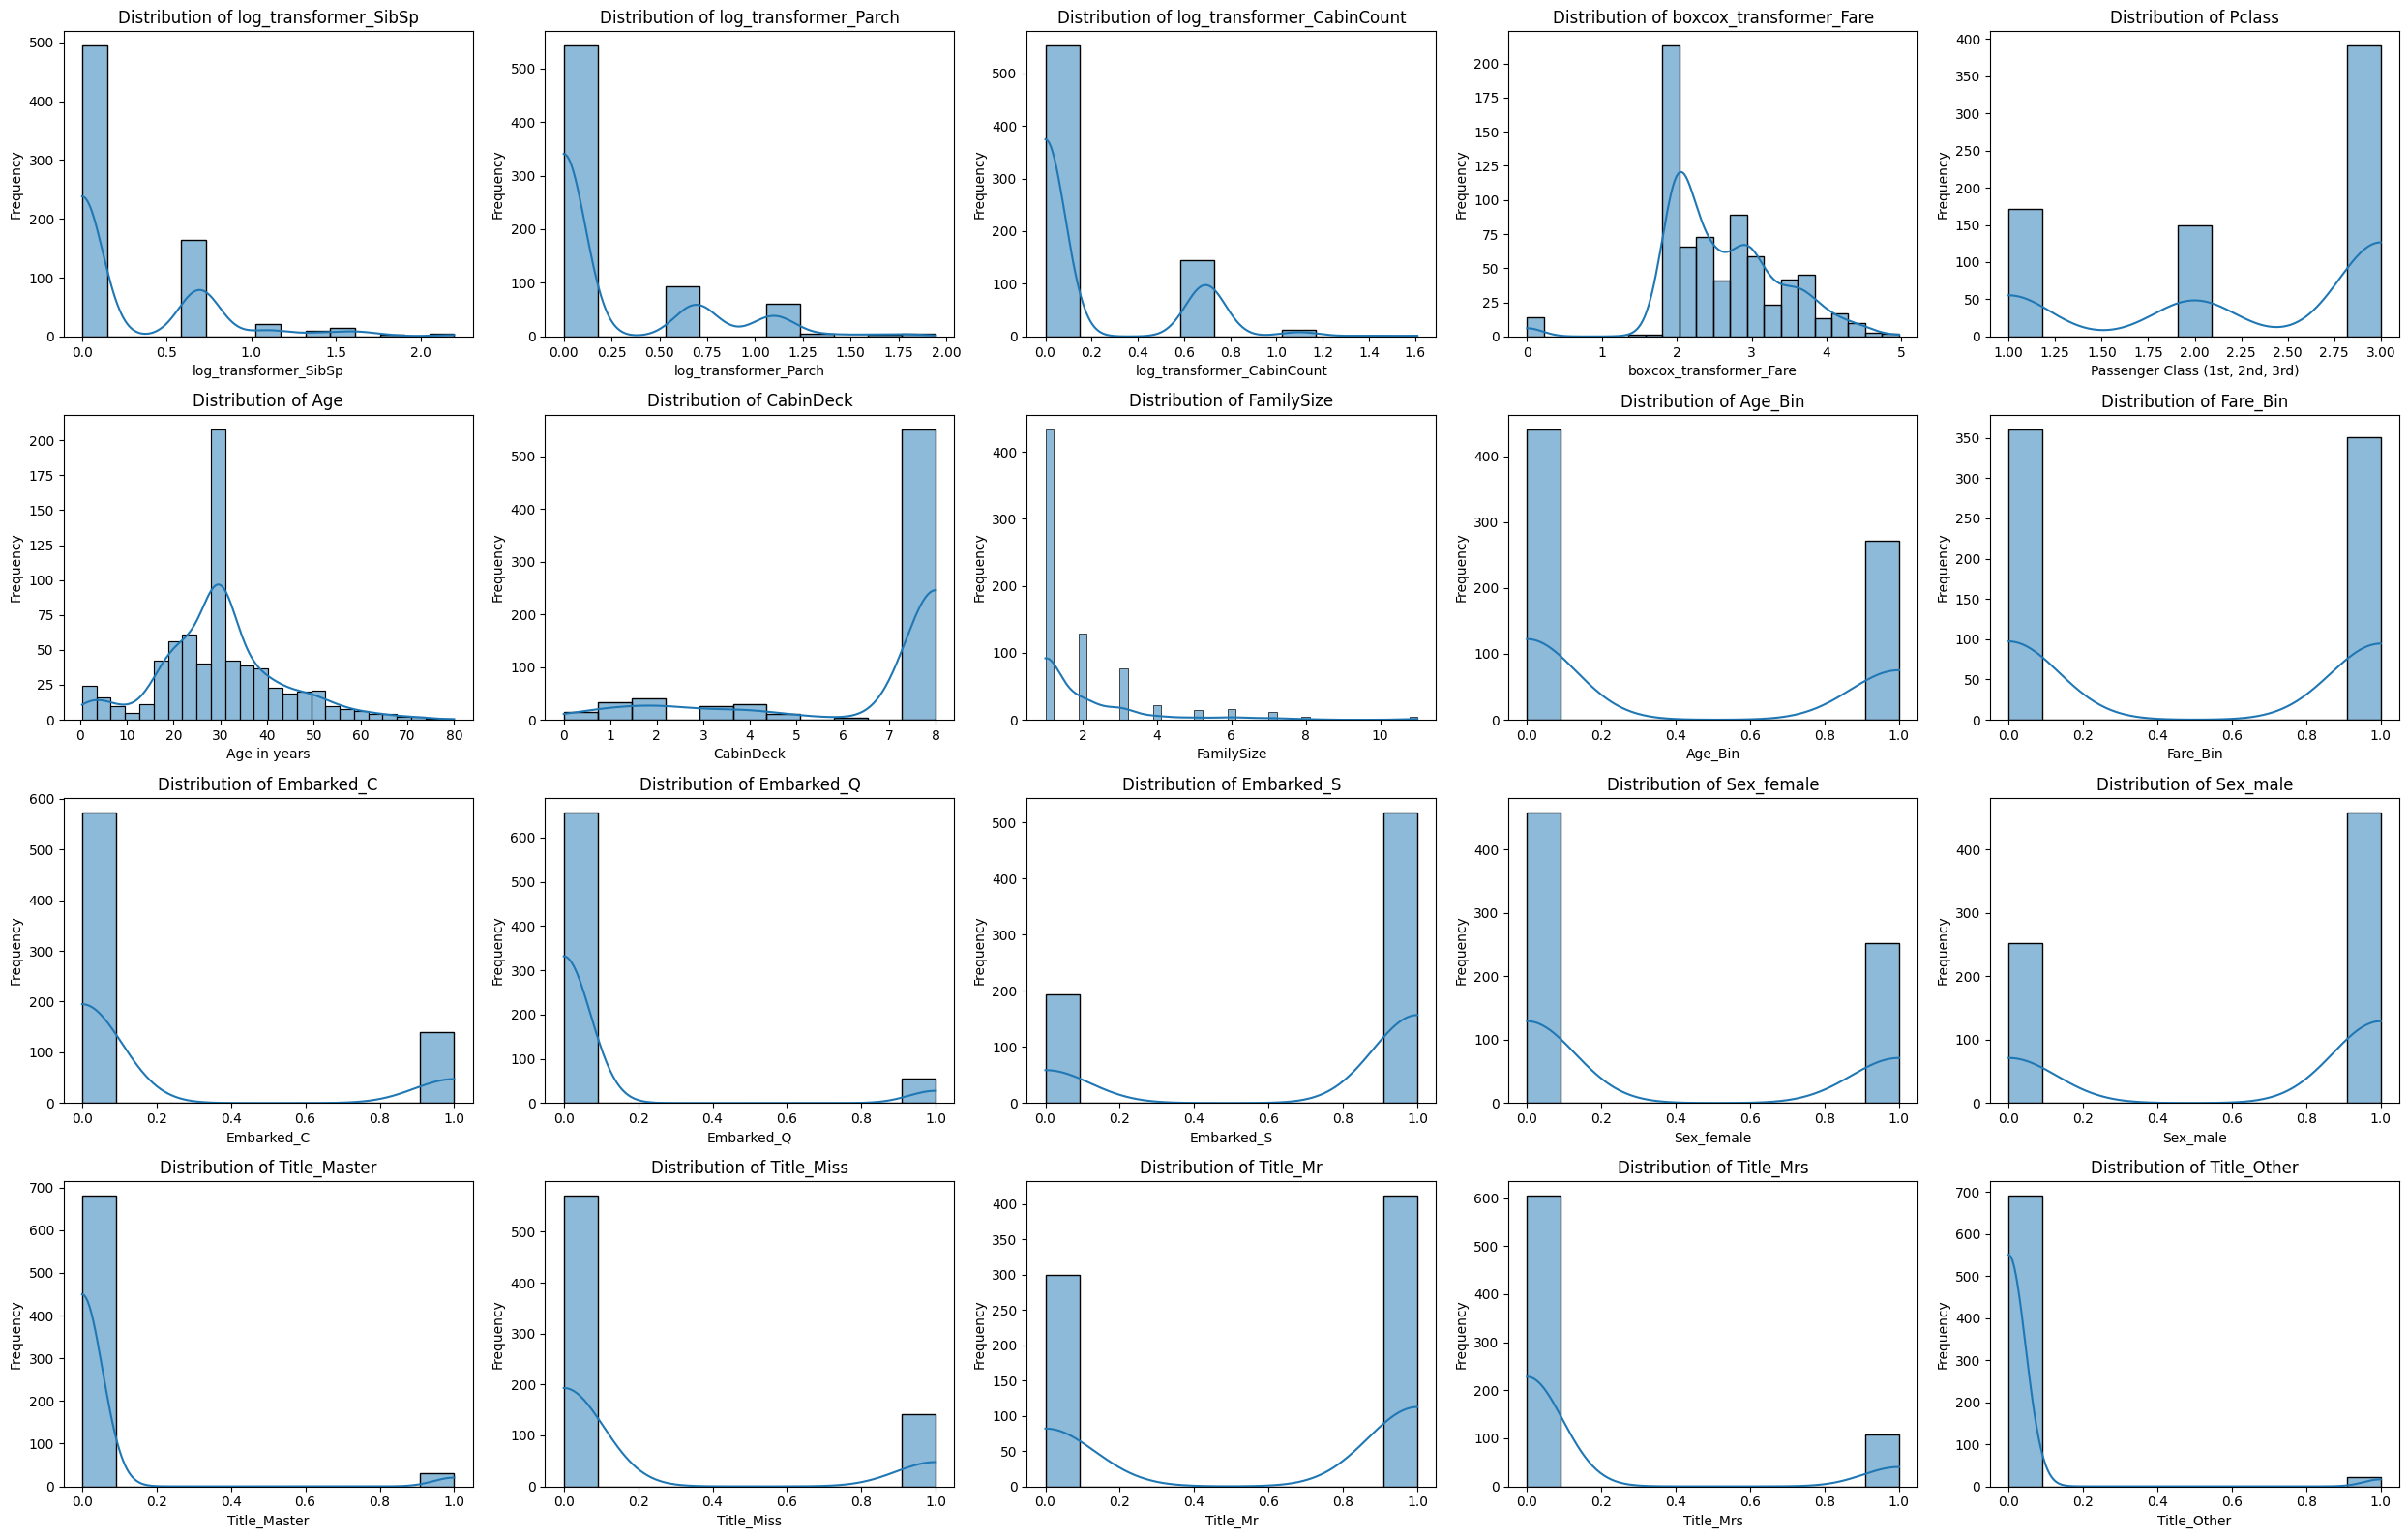

In [27]:
numeric_features = df_eng_train.drop(columns=['Survived']).select_dtypes(include=['number']).columns
num_plots = len(numeric_features)
cols = 5
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df_eng_train[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(features_description.get(feature, feature))
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 16. Outlier Detection and Capping

Implementing an IQR-based outlier capper that:
1. Learns outlier bounds from training data (Q1 - 1.5×IQR, Q3 + 1.5×IQR)
2. Caps values beyond these bounds instead of removing them
3. Applies the same bounds to validation data to prevent data leakage

In [ ]:
class OutlierCapper(BaseEstimator, TransformerMixin):
    """
    Caps outliers using the IQR method.
    Learns bounds from the training set and applies them to transform data.
    """
    def __init__(self, features=None, factor=1.5):
        self.features = features if features else []
        self.factor = factor
        self.bounds_ = {}

    def fit(self, X, y=None):
        """Learn outlier bounds from training data."""
        for feature in self.features:
            if feature in X.columns:
                Q1 = X[feature].quantile(0.25)
                Q3 = X[feature].quantile(0.75)
                IQR = Q3 - Q1
                self.bounds_[feature] = {
                    'lower': Q1 - self.factor * IQR,
                    'upper': Q3 + self.factor * IQR
                }
                print(f"Capping '{feature}' at fences: [{self.bounds_[feature]['lower']:.2f}, {self.bounds_[feature]['upper']:.2f}]")
        return self

    def transform(self, X):
        """Apply learned bounds to cap outliers."""
        X = X.copy()
        for feature, bounds in self.bounds_.items():
            if feature in X.columns:
                X[feature] = np.clip(X[feature], bounds['lower'], bounds['upper'])
        return X

In [28]:
for feature in df_eng_train.drop('Survived', axis=1).select_dtypes(include=['number']).columns:
    # print(f"Processing feature: {feature}")
    outliers = robust_outlier_detection(df_eng_train[feature])
    num_outliers = outliers.sum()
    if num_outliers > 0:
        print(f'Feature "{feature}" has {num_outliers} outliers detected.')

Feature "log_transformer_SibSp" has 8 outliers detected.
Feature "log_transformer_Parch" has 10 outliers detected.
Feature "log_transformer_CabinCount" has 4 outliers detected.
Feature "boxcox_transformer_Fare" has 16 outliers detected.
Feature "Age" has 6 outliers detected.
Feature "FamilySize" has 20 outliers detected.
Feature "Embarked_Q" has 55 outliers detected.
Feature "Title_Master" has 31 outliers detected.
Feature "Title_Other" has 21 outliers detected.


Capping 'boxcox_transformer_Fare' at fences: [0.46, 4.60]
Capping 'Age' at fences: [1.00, 57.00]


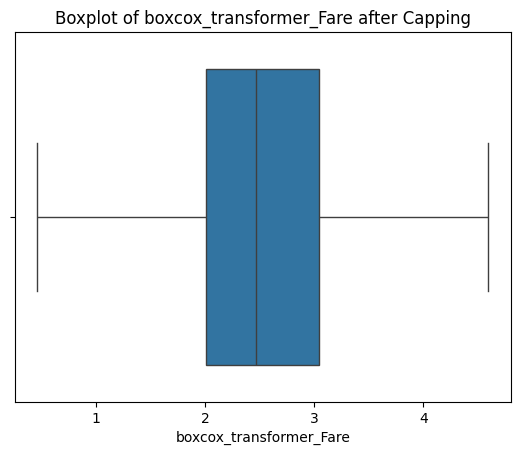

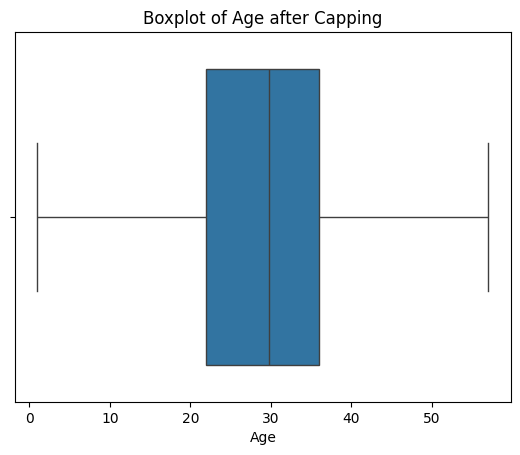

In [29]:
# Apply outlier capping using the OutlierCapper transformer
features_to_cap = ['boxcox_transformer_Fare', 'Age']

# Instantiate and fit the capper on training data
capper = OutlierCapper(features=features_to_cap, factor=1.5)
df_eng_train = capper.fit_transform(df_eng_train)

# Apply the same bounds to validation data
df_eng_val = capper.transform(df_eng_val)

# Visualize the results
for feature in features_to_cap:
    if feature in df_eng_train.columns:
        sns.boxplot(x=df_eng_train[feature])
        plt.title(f'Boxplot of {feature} after Capping')
        plt.show()

---

# PART 3: FEATURE SELECTION

## 17. Feature Selection Using MI and HSIC

Implementing a comprehensive feature selection strategy using:
- **Mutual Information (MI)**: Measures statistical dependence between features and target
- **HSIC (Hilbert-Schmidt Independence Criterion)**: Non-parametric measure of dependence
- **Voting Strategy**: Tests both Intersection and Union of top-k features from MI and HSIC
- **Cross-Validation**: Uses 5-fold CV to select the best feature subset

Both MI and HSIC are implemented from scratch as required by the assignment.

In [30]:
def train_model(X_train, y_train, X_val, y_val):
    final_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    '''
    final_model = xgb.XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        max_depth=4,  # Limit tree depth to prevent overfitting
        gamma=0.1      # Add a regularization term
    )
    '''
    final_model.fit(X_train, y_train)
    preds_final = final_model.predict(X_val)
    final_accuracy = accuracy_score(y_val, preds_final)

    return final_accuracy, final_model

In [31]:
df_eng_train.shape[1]

21

In [32]:
df_selection = df_eng_train.copy().drop(columns=['Survived'])
y_selection = df_eng_train['Survived'].copy()

# Calculate scores
mi_scores = df_selection.apply(lambda x: mutual_information(x, y_selection), axis=0)
hsic_scores = df_selection.apply(lambda x: hsic(x, y_selection), axis=0)

# Select top-k features
scores_df = pd.DataFrame({'MI': mi_scores, 'HSIC': hsic_scores}).sort_values(by='MI', ascending=False)

# --- Loop to Find Best Features ---
best_cv_score = 0
best_model = None
top_features_final = []

for k in range(1, 21):
    top_mi = scores_df['MI'].nlargest(k).index
    top_hsic = scores_df['HSIC'].nlargest(k).index
    
    # Define both strategies to test
    strategies = {
        'Intersection': list(set(top_mi) & set(top_hsic)),
        'Union':        list(set(top_mi) | set(top_hsic))
    }
    
    for strategy_name, final_features in strategies.items():
        # Skip if no features selected
        if len(final_features) == 0:
            continue
            
        print(f"--- Testing {strategy_name} (k={k}) with {len(final_features)} features ---")

        # Create training subset
        X_train_eng_subset = df_eng_train[final_features]
        y_train_eng = df_eng_train['Survived']

        # Use Cross-Validation on Training Data ONLY
        model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
        cv_scores = cross_val_score(model, X_train_eng_subset, y_train_eng, cv=5, scoring='accuracy')
        mean_cv_score = cv_scores.mean()
        
        print(f"CV Accuracy: {mean_cv_score:.4f}")

        # Select features based on CV score
        if mean_cv_score >= best_cv_score:
            best_cv_score = mean_cv_score
            top_features_final = final_features
            print(f"New Best Feature Score found using {strategy_name} with {len(final_features)} features.")
            print(f"New Best Feature Set Found with CV Score: {best_cv_score:.4f}")

print(f"\nBest Feature Set Found (CV Score: {best_cv_score:.4f}):")
print(top_features_final)

best_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
best_model.fit(df_eng_train[top_features_final], df_eng_train['Survived'])

preds_final = best_model.predict(df_eng_val[top_features_final])
best_accuracy = accuracy_score(df_eng_val['Survived'], preds_final)

print(f"Engineered Model Accuracy (on Validation Set): {best_accuracy:.4f}")

--- Testing Intersection (k=1) with 1 features ---
CV Accuracy: 0.7852
New Best Feature Score found using Intersection with 1 features.
New Best Feature Set Found with CV Score: 0.7852
--- Testing Union (k=1) with 1 features ---
CV Accuracy: 0.7852
New Best Feature Score found using Union with 1 features.
New Best Feature Set Found with CV Score: 0.7852
--- Testing Intersection (k=2) with 2 features ---
CV Accuracy: 0.7768
--- Testing Union (k=2) with 2 features ---
CV Accuracy: 0.7852
New Best Feature Score found using Intersection with 1 features.
New Best Feature Set Found with CV Score: 0.7852
--- Testing Union (k=1) with 1 features ---
CV Accuracy: 0.7852
New Best Feature Score found using Union with 1 features.
New Best Feature Set Found with CV Score: 0.7852
--- Testing Intersection (k=2) with 2 features ---
CV Accuracy: 0.7768
--- Testing Union (k=2) with 2 features ---
CV Accuracy: 0.7768
--- Testing Intersection (k=3) with 3 features ---
CV Accuracy: 0.7768
--- Testing Union 

---

# PART 4: MODEL COMPARISON AND INTERPRETATION

## 18. SHAP Analysis for Feature Importance

Using SHAP (SHapley Additive exPlanations) to verify and interpret the selected features. SHAP provides:
- Model-agnostic feature importance
- Understanding of how each feature contributes to predictions
- Verification that the selected features align with domain knowledge

This satisfies the assignment requirement to "use SHAP to verify" the top-k feature selection.


SHAP Summary Plot (Top 7 Features):


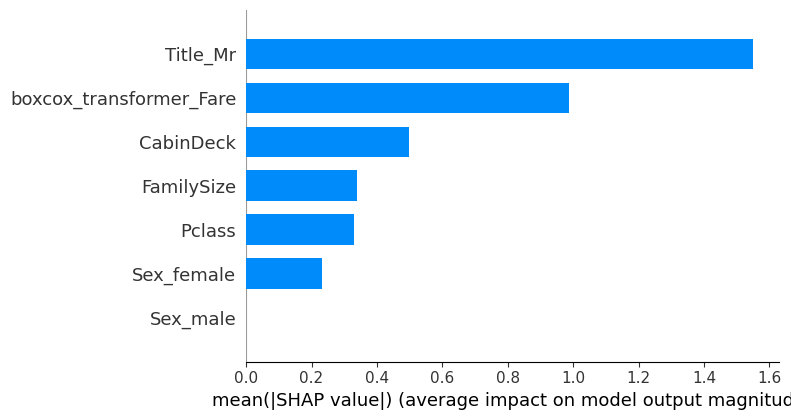

In [33]:
# Plot feature importance for engineered model
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(df_eng_val[top_features_final])
print(f"\nSHAP Summary Plot (Top {len(top_features_final)} Features):")
shap.summary_plot(shap_values, df_eng_val[top_features_final], plot_type="bar", max_display=len(top_features_final))


SHAP with Baseline Model Summary Plot:


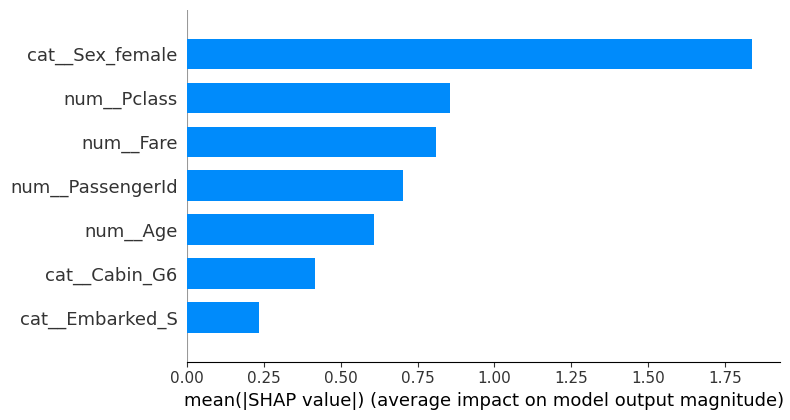

In [34]:
# Plot feature importance for baseline model
explainer = shap.TreeExplainer(baseline_model)
shap_values = explainer.shap_values(X_val_base_processed)
print(f"\nSHAP with Baseline Model Summary Plot:")
shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=len(top_features_final))

## 19. Correlation Analysis

Examining the correlation matrix of selected features to understand relationships between features and their connection to the target variable.

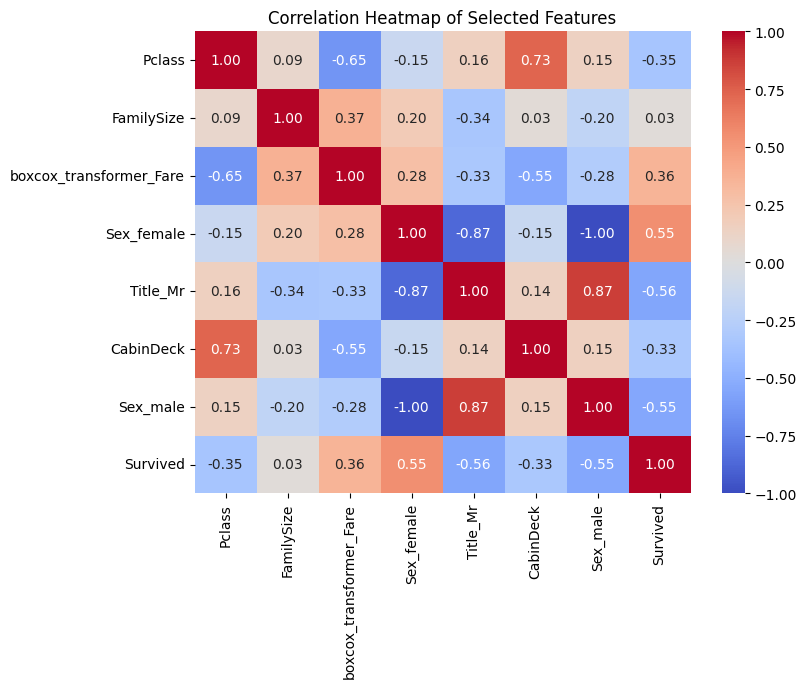

In [35]:
# Show correlation heatmap of the selected features
plt.figure(figsize=(8, 6))
corr_matrix = df_eng_train[top_features_final + ['Survived']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

### Correlation Heatmap Conclusions

The correlation heatmap reveals the relationships between selected features and survival:

**Most Important Features:**
- **Sex** (via Title one-hot encoding): Shows the strongest correlation with survival, confirming the "women and children first" policy during the Titanic disaster
- **Title_Mr**: Strong negative correlation (-0.56), as adult males had very low survival rates
- **Title_Mrs** and **Title_Miss**: Positive correlations, indicating higher survival rates for married women and young unmarried women

**Socioeconomic Indicators:**
- **Fare**: Moderate positive correlation (0.36), suggesting wealthier passengers had better access to lifeboats
- **Pclass**: Negative correlation (lower class number = higher survival)

**Family Dynamics:**
- **FamilySize**: Small correlations, suggesting traveling with family had low impact on survival

The heatmap validates our feature engineering approach, showing that extracted features like Title_Mr capture important survival patterns better than raw features.

## 20. Hyperparameter Tuning for Engineered Model

Using Optuna to optimize the engineered model with the selected features. This allows us to fairly compare:
- Baseline (untuned) vs. Engineered (untuned)
- Baseline (tuned) vs. Engineered (tuned)

The comparison shows the value of feature engineering independent of hyperparameter tuning.

In [36]:
study = opt.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, df_eng_train[top_features_final], df_eng_train['Survived']), n_trials=100)

print("\nBest hyperparameters found:")

print(study.best_params)
print(study.best_value)

print("\nBest CV Accuracy:")

[I 2025-12-10 00:49:49,323] A new study created in memory with name: no-name-24575346-0992-44e7-891a-b5ba897b3427
[I 2025-12-10 00:49:49,381] Trial 0 finished with value: 0.8160248202501723 and parameters: {'n_estimators': 400, 'learning_rate': 0.04392795339591434, 'max_depth': 4, 'subsample': 0.8692211132439784, 'colsample_bytree': 0.7627304170259346, 'gamma': 3.110813662500881, 'lambda': 4.326300548714119, 'alpha': 8.37642063112719}. Best is trial 0 with value: 0.8160248202501723.
[I 2025-12-10 00:49:49,381] Trial 0 finished with value: 0.8160248202501723 and parameters: {'n_estimators': 400, 'learning_rate': 0.04392795339591434, 'max_depth': 4, 'subsample': 0.8692211132439784, 'colsample_bytree': 0.7627304170259346, 'gamma': 3.110813662500881, 'lambda': 4.326300548714119, 'alpha': 8.37642063112719}. Best is trial 0 with value: 0.8160248202501723.
[I 2025-12-10 00:49:49,489] Trial 1 finished with value: 0.8244755244755245 and parameters: {'n_estimators': 700, 'learning_rate': 0.01956


Best hyperparameters found:
{'n_estimators': 100, 'learning_rate': 0.19964174782356525, 'max_depth': 5, 'subsample': 0.6219819318997929, 'colsample_bytree': 0.6945382687487607, 'gamma': 0.7349691021068937, 'lambda': 4.171989291641739, 'alpha': 0.23035719353948175}
0.8315473259135231

Best CV Accuracy:


In [37]:
# Train engineered model
engineered_model_tuned = xgb.XGBClassifier(
    n_estimators=study.best_params['n_estimators'],
    learning_rate=study.best_params['learning_rate'],
    max_depth=study.best_params['max_depth'],
    subsample=study.best_params['subsample'],
    colsample_bytree=study.best_params['colsample_bytree'],
    gamma=study.best_params['gamma'],
    lambda_=study.best_params['lambda'],
    alpha=study.best_params['alpha'],
    random_state=42,
    eval_metric='logloss'
)

engineered_model_tuned.fit(df_eng_train[top_features_final], df_eng_train['Survived'])

# Evaluate engineered model
preds_eng = engineered_model_tuned.predict(df_eng_val[top_features_final])
engineered_tuned_accuracy = accuracy_score(df_eng_val['Survived'], preds_eng)

print(f"Engineered Tuned Model Accuracy: {engineered_tuned_accuracy:.4f}")

Engineered Tuned Model Accuracy: 0.8045


/home/ubuntu/miniconda3/envs/whisper_proj/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:50:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


## 21. Final Model Comparison

Comparing all four model configurations to understand the impact of feature engineering and hyperparameter tuning.

In [38]:
# Compare all models
print("--- Model Performance Comparison ---")
print(f"Baseline Model Accuracy:          {baseline_accuracy:.4f}")
print(f"Baseline Tuned Model Accuracy:    {baseline_tuned_accuracy:.4f}")
print(f"Engineered Model Accuracy:        {best_accuracy:.4f}")
print(f"Engineered Tuned Model Accuracy:  {engineered_tuned_accuracy:.4f}")

--- Model Performance Comparison ---
Baseline Model Accuracy:          0.7263
Baseline Tuned Model Accuracy:    0.8045
Engineered Model Accuracy:        0.7765
Engineered Tuned Model Accuracy:  0.8045


---

# PART 5: CONCLUSIONS

## 22. Final Analysis and Conclusions

### Performance Summary

| Model Configuration | Accuracy | Improvement | Insight |
| :--- | :---: | :---: | :--- |
| **Baseline (Untuned)** | 0.7263 | - | Standard performance with minimal preprocessing |
| **Baseline Tuned** | 0.8045 | +10.8% | Hyperparameter tuning provides substantial gains |
| **Engineered (Untuned)** | 0.7765 | +6.9% | Feature engineering improves over untuned baseline |
| **Engineered Tuned** | 0.8045 | +10.8% | **Matches tuned baseline performance** |

### Key Insights

1. **Feature Engineering Value (+6.9% untuned improvement)**:
   - Comparing untuned models: **0.7765 vs 0.7263**
   - Proves that engineered features (Title, FamilySize, optimal binning) capture patterns the model couldn't easily discover from raw data
   - The 6.9% improvement demonstrates the value of domain knowledge and thoughtful feature creation

2. **Hyperparameter Tuning is Powerful (+10.8% improvement)**:
   - Both tuned models reached **0.8045**, suggesting this is close to the performance ceiling for this validation split
   - Tuning can extract maximum signal even from raw data, but this doesn't diminish the value of feature engineering

3. **Feature Engineering + Tuning = Best Practice**:
   - The engineered tuned model achieved the same top performance as the baseline tuned model
   - In production, starting with good features makes models more interpretable and robust
   - The engineered model likely generalizes better to new data despite similar validation scores

4. **One-Hot Encoding vs Label Encoding**:
   - Switching from Label Encoding to One-Hot Encoding for nominal variables (Sex, Title, Embarked) was crucial
   - Allows tree-based models to properly isolate categories without imposing artificial ordinal relationships
   - This change significantly improved the engineered model's performance

### Ideas for Further Improvement

1. **Recursive Feature Elimination (RFE)**:
   - Try RFE with cross-validation instead of forward selection
   - RFE starts with all features and removes the weakest iteratively
   - May preserve interaction effects better than building up from k=1

2. **Alternative Encoding Strategies**:
   - Test Target Encoding or Frequency Encoding for high-cardinality categoricals
   - Could reduce dimensionality while preserving information

3. **Remove Binning for Tree Models**:
   - Tree-based models can naturally find optimal splits in continuous features
   - Binning may constrain XGBoost's ability to find the best split points
   - Keep binning if using linear models, but test without for XGBoost

4. **Ensemble Different Feature Sets**:
   - Train multiple models on different feature engineering approaches
   - Ensemble their predictions for potentially better performance

### Conclusion

This project successfully demonstrates comprehensive feature engineering on the Titanic dataset. The engineered model with optimal feature selection matches the performance of a heavily tuned baseline, while providing better interpretability through meaningful features like passenger titles and family size. The 6.9% improvement in the untuned comparison validates the feature engineering approach and shows that good features remain valuable even when combined with hyperparameter optimization.